# Preliminary Operations
The same imports and auxiliary code is defined below:

In [ ]:
from google.colab import drive
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import random as rn
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications.resnet50 import preprocess_input

#drive.mount('/content/drive')

In [ ]:
#ROOT_DIR = "/content/drive/Shareddrives/Giaquinta_Pasqualetti/"
ROOT_DIR = "/content/sample_data/content/drive/Shareddrives/Giaquinta_Pasqualetti/"

IMAGES_DIR = os.path.join(ROOT_DIR, "Data")
TRAIN_DIR = os.path.join(IMAGES_DIR, "Train")
TEST_DIR = os.path.join(IMAGES_DIR, "Test")

IMAGE_DIM = 64
RAN_SEED = 10024062

VALIDATION_SPLIT = 0.1
TRAIN_SPLIT = 0.2

NOTE: Interactions with Google Drive are commented out. For our own testing, we used files stored locally in the session to **significantly** speed up the computation. To run this notebook using files stored in Google Drive, uncomment the lines that are currently commented and comment out the lines that are using local files.

In [ ]:
#! rm -r /content/drive/Shareddrives/Giaquinta_Pasqualetti/Data
#! unzip -q /content/drive/Shareddrives/Giaquinta_Pasqualetti/Data.zip -d /

! rm -r /content/sample_data/*
! unzip -q /content/Data.zip -d /content/sample_data/

In [ ]:
# Set all the seeds, to create datasets and Tensors from the same starting point
def set_seed():
    os.environ["PYTHONHASHSEED"]="0"
    np.random.seed(RAN_SEED)
    rn.seed(RAN_SEED)
    tf.random.set_seed(RAN_SEED)

# Returns Train, Val and Test sets
# BATCH_SIZE is user-given input, VALIDATION_SPLIT is 0.1
def load_datasets(BATCH_SIZE):
    set_seed()

    train = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR, labels='inferred', label_mode='categorical', class_names=None,
        color_mode='rgb', batch_size=BATCH_SIZE, shuffle=True, seed=RAN_SEED,
        validation_split=VALIDATION_SPLIT, subset='training', follow_links=False,
        image_size=(64,64)
    )

    val = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR, labels='inferred', label_mode='categorical', class_names=None,
        color_mode='rgb', batch_size=BATCH_SIZE, shuffle=True, seed=RAN_SEED,
        validation_split=VALIDATION_SPLIT, subset='validation', follow_links=False,
        image_size=(64,64)
    )

    test = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DIR, labels='inferred', label_mode='categorical',
        class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, shuffle=True,
        seed=RAN_SEED, follow_links=False, image_size=(64,64)
    )

    return train, val, test

# Returns some details about trained model
def train_performance(history):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

# Test
def show_res(model, test):
  data, labels = [], []

  for data_batch, labels_batch in test:
    data.append(data_batch)
    labels.append(labels_batch)

  data = tf.concat(data, axis=0)
  labels = tf.concat(labels, axis=0)

  y_score = model.predict(data)

  y_pred = np.rint(y_score)

  y_true = np.asarray(labels)

  y_pred = np.argmax(y_score, axis=1)
  y_test = np.argmax(y_true, axis=1)

  print("Classification report: ")
  print(metrics.classification_report(y_test,y_pred ,digits = 4))


  cm = metrics.confusion_matrix(y_test, y_pred)
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()


# Function to plot multi-class ROC curves
def plot_multiclass_roc(model, test_data):
    test_images, test_labels = [], []

    for data_batch, labels_batch in test_data:
        test_images.append(data_batch)
        test_labels.append(labels_batch)

    test_images = np.concatenate(test_images, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # Preprocess images
    test_images = preprocess_input(test_images)

    # Get predicted scores for all classes
    y_scores = model.predict(test_images)

    # Binarize labels
    y_true = label_binarize(np.argmax(test_labels, axis=1), classes=range(10))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves in a single plot
    plt.figure(figsize=(10, 8))
    for i in range(10):
        plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curves')
    plt.legend(loc="lower right")
    plt.show()


def model_summary(model):
  from keras.utils.vis_utils import plot_model

  model.summary()
  plot_model(model, show_shapes=True, show_layer_names=True)


# ResNet50 with Feature Extraction
Importing the **ResNet50** Keras model. ResNet50 is a powerful deep neural network architecture renowned for its innovation in tackling the vanishing gradient problem through residual connections. With 50 layers, it's designed to capture intricate features and patterns, making it highly effective for image classification tasks. ResNet50's pre-trained weights allow seamless adaptation to new tasks, rendering it a popular choice for transfer learning.

Employing ResNet50 for satellite image land use classification offers distinct advantages. Its advanced residual connections enable it to efficiently capture complex relationships within the data, allowing for the recognition of nuanced land use patterns. The pre-trained weights empower quick model customization, particularly valuable when working with limited labeled data. ResNet50 accommodates larger input sizes, a crucial trait for processing satellite images. Its adaptability to diverse landscapes, coupled with its interpretability, makes it a suitable candidate for enhancing visual insights.

In [ ]:
from tensorflow.keras.applications import ResNet50V2

conv_base = keras.applications.resnet.ResNet50(
    include_top = False,
    weights='imagenet',
    input_shape=(64, 64, 3))

conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

Layer freezing is needed to fix the weights of certain neural network layers during training, commonly for transfer learning, to retain learned features and prevent them from being changed.

In [ ]:
print('Number of trainable weights: ', sum(np.prod(x.shape) for x in conv_base.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the convolutional base:', sum(np.prod(x.shape) for x in conv_base.trainable_weights))

Number of trainable weights:  23534592
Number of trainable weights after freezing the convolutional base: 0


## **First try:** 256 neurons with adam optimizer
The conv_base initiates the feature extraction phase. As our parameters we decided to set the number of neurons in the dense layer to 256 and the number of neurons in the dense layer to 256, without any L2 regularization, dropout or data augmentation, which will be later added if necessary. The chosen optimizer is Adam.

In [ ]:
inputs = keras.Input(shape=(64, 64, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu') (x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.__operators__.getitem_1   (None, 64, 64, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
        #'/content/drive/Shareddrives/Giaquinta_Pasqualetti/Models/resnet50_simple.h5',
        '/content/resnet50_simple.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    )
]

Found 22000 files belonging to 10 classes.
Using 19800 files for training.
Found 22000 files belonging to 10 classes.
Using 2200 files for validation.
Found 5400 files belonging to 10 classes.
Epoch 1/15
310/310 [==============================] - 14s 31ms/step - loss: 0.4584 - accuracy: 0.8819 - val_loss: 0.2458 - val_accuracy: 0.9195
Epoch 2/15
310/310 [==============================] - 8s 27ms/step - loss: 0.1359 - accuracy: 0.9523 - val_loss: 0.2472 - val_accuracy: 0.9268
Epoch 3/15
310/310 [==============================] - 8s 27ms/step - loss: 0.0740 - accuracy: 0.9737 - val_loss: 0.2711 - val_accuracy: 0.9291
Epoch 4/15
310/310 [==============================] - 8s 25ms/step - loss: 0.0518 - accuracy: 0.9806 - val_loss: 0.2556 - val_accuracy: 0.9386
Epoch 5/15
310/310 [==============================] - 9s 27ms/step - loss: 0.0378 - accuracy: 0.9870 - val_loss: 0.3016 - val_accuracy: 0.9309
Epoch 6/15
310/310 [==============================] - 8s 27ms/step - loss: 0.0471 - accurac

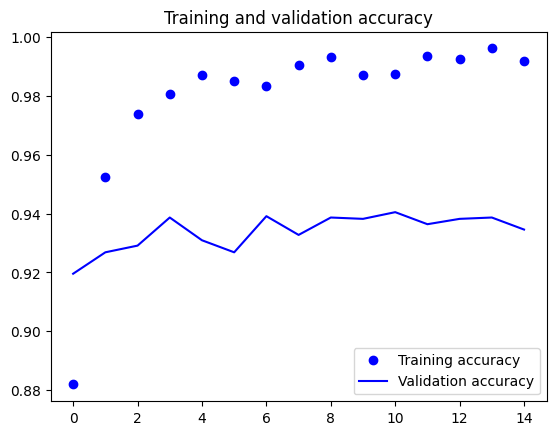

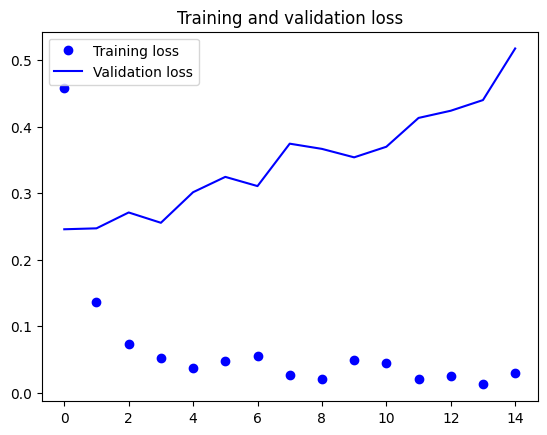

169/169 [==============================] - 3s 14ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9485    0.8900    0.9183       600
           1     0.9776    0.9450    0.9610       600
           2     0.9207    0.9283    0.9245       600
           3     0.8957    0.7900    0.8395       500
           4     0.9368    0.9780    0.9569       500
           5     0.8608    0.9275    0.8929       400
           6     0.8623    0.9140    0.8874       500
           7     0.9657    0.9867    0.9761       600
           8     0.8858    0.9000    0.8929       500
           9     0.9769    0.9883    0.9826       600

    accuracy                         0.9269      5400
   macro avg     0.9231    0.9248    0.9232      5400
weighted avg     0.9275    0.9269    0.9265      5400



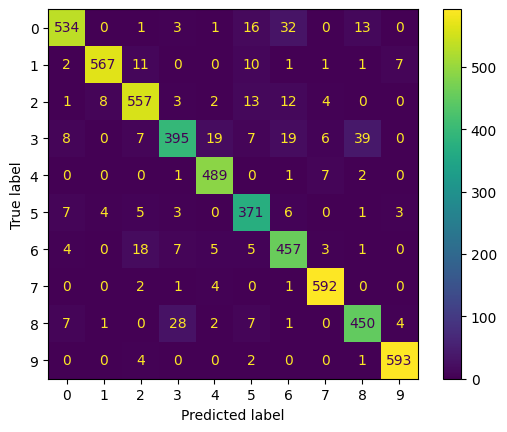

169/169 [==============================] - 2s 13ms/step


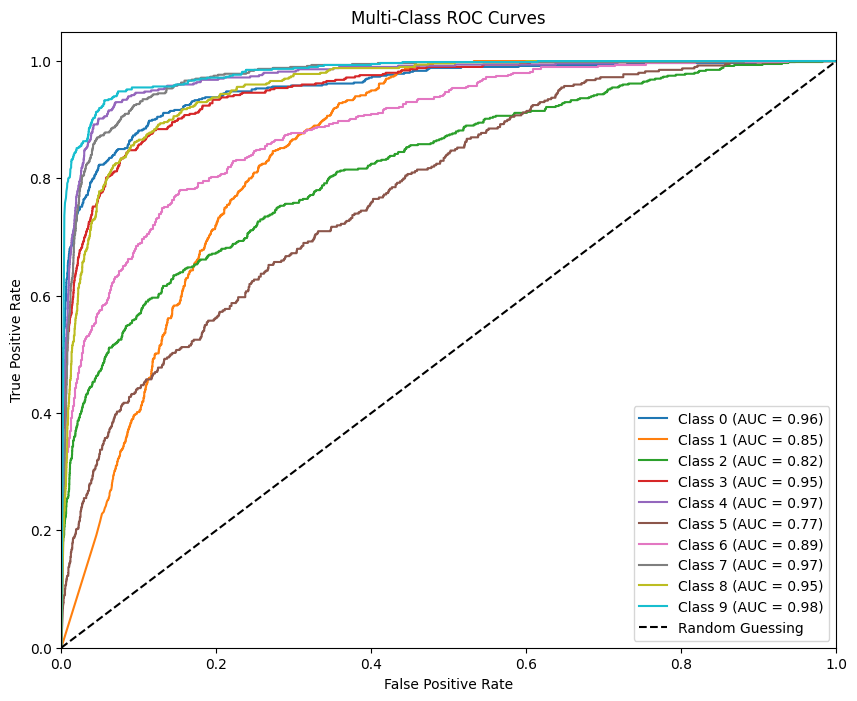

In [ ]:
train, val, test = load_datasets(BATCH_SIZE = 64)
res = model.fit(train, epochs=15, validation_data=val, callbacks = callbacks_list)
train_performance(res)
show_res(model, test)
plot_multiclass_roc(model, test)

## **Second try:** addressing the overfitting (again)
The results indicate that the validation accuracy is lower than the training accuracy, and the validation loss is higher than the training loss by a significant margin. It is possible that the accuracy might not improve significantly or not improve at all. However, let's attempt to reduce overfitting so that the classification model is sufficiently generalized to consistently deliver this level of performance. To begin with, we will implement dropout and add a data augmentation layer.

Let's repeat the experiment:

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.__operators__.getitem_2   (None, 64, 64, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097

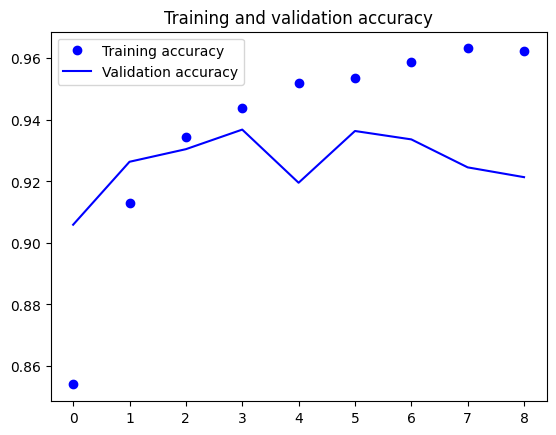

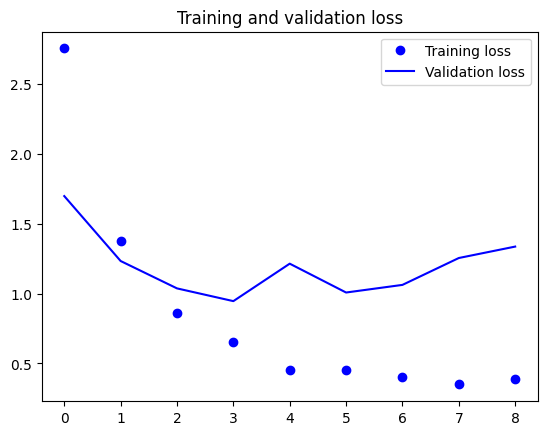

169/169 [==============================] - 3s 13ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9604    0.8900    0.9239       600
           1     0.9627    0.9467    0.9546       600
           2     0.8974    0.9183    0.9077       600
           3     0.8396    0.8480    0.8438       500
           4     0.8919    0.9900    0.9384       500
           5     0.9137    0.9000    0.9068       400
           6     0.8460    0.8900    0.8674       500
           7     0.9854    0.9000    0.9408       600
           8     0.8996    0.8780    0.8887       500
           9     0.9567    0.9950    0.9755       600

    accuracy                         0.9172      5400
   macro avg     0.9153    0.9156    0.9148      5400
weighted avg     0.9188    0.9172    0.9173      5400



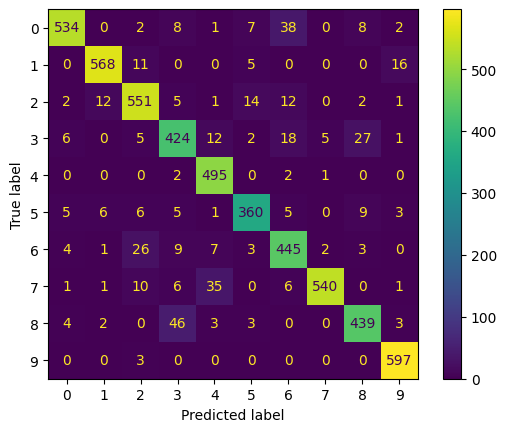

169/169 [==============================] - 2s 13ms/step


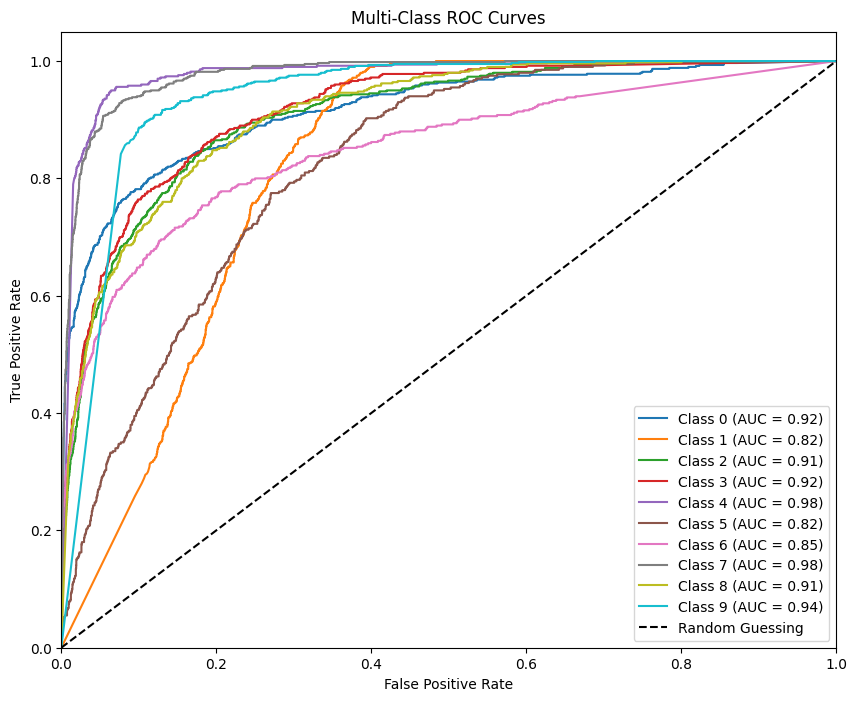

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

inputs = keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = inputs
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model.summary()

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
        #'/content/drive/Shareddrives/Giaquinta_Pasqualetti/Models/resnet50_dropout_augment.h5',
        '/content/resnet50_dropout_augment.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    )
]

train, val, test = load_datasets(BATCH_SIZE = 64)
res = model.fit(train, epochs=15, validation_data=val, callbacks = callbacks_list)
train_performance(res)
show_res(model, test)
plot_multiclass_roc(model, test)

## **Third try:** Data regularization
Presently, an instance of overfitting can still be observed. The magnitude of the problem has decreased thanks to the dropout and data augmentation layer. Let's attempt to address this once and for all by also incorporating L2 regularization into the dense layer.

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.__operators__.getitem_3   (None, 64, 64, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097

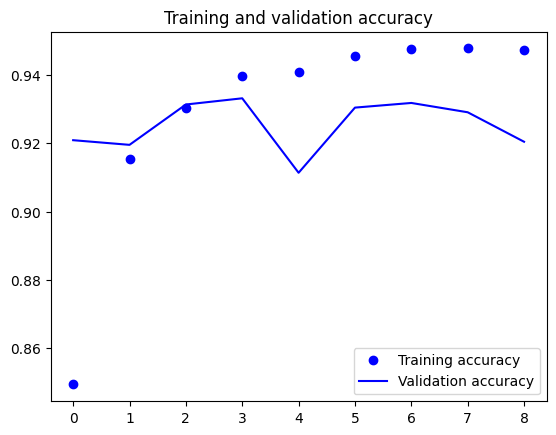

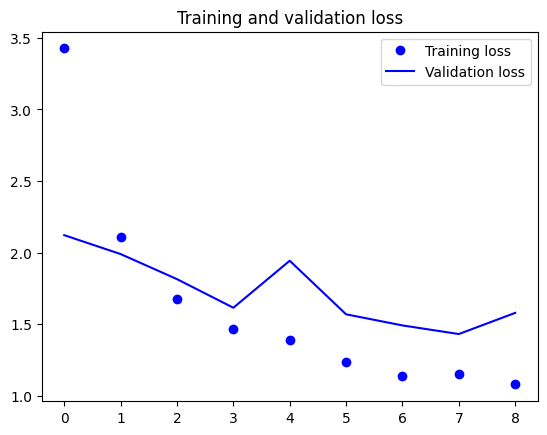

169/169 [==============================] - 3s 14ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8499    0.9717    0.9067       600
           1     0.9285    0.9733    0.9504       600
           2     0.9236    0.8667    0.8942       600
           3     0.8275    0.8540    0.8406       500
           4     0.9542    0.9580    0.9561       500
           5     0.8997    0.8750    0.8872       400
           6     0.9701    0.7140    0.8226       500
           7     0.9366    0.9850    0.9602       600
           8     0.8849    0.8920    0.8884       500
           9     0.9722    0.9917    0.9818       600

    accuracy                         0.9133      5400
   macro avg     0.9147    0.9081    0.9088      5400
weighted avg     0.9157    0.9133    0.9120      5400



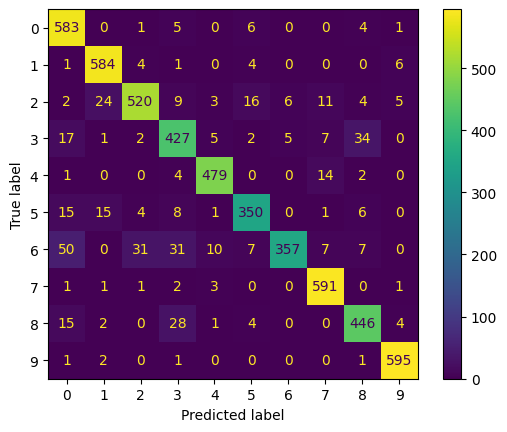

169/169 [==============================] - 2s 13ms/step


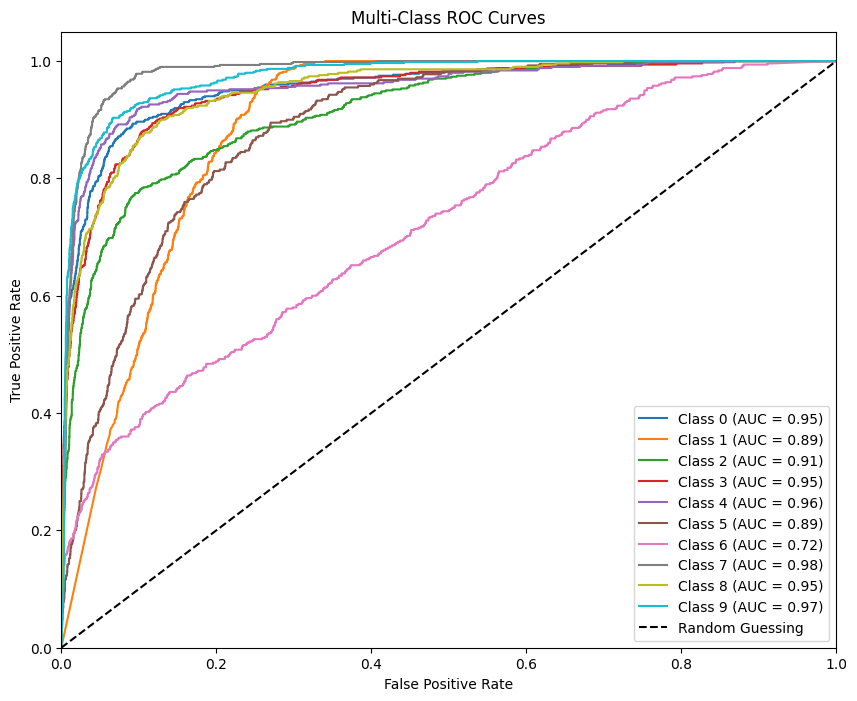

In [ ]:
from keras.regularizers import l2

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

inputs = keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = inputs
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, kernel_regularizer=l2(0.001))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model.summary()

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
        #'/content/drive/Shareddrives/Giaquinta_Pasqualetti/Models/resnet50_final.h5',
        '/content/resnet50_final.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    )
]

train, val, test = load_datasets(BATCH_SIZE = 64)
res = model.fit(train, epochs=15, validation_data=val, callbacks = callbacks_list)
train_performance(res)
show_res(model, test)
plot_multiclass_roc(model, test)

# Fine Tuning
Fine-tuning assumes that a model has been trained on similar data and with similar classes, once again, this experiment may not lead to satisfactory results but we will try it anyways.

The model is composed of 174 layers as we can see below, and the last conv block will be unfreezed and rendered trainable:

In [ ]:
#model = tf.keras.models.load_model('/content/drive/Shareddrives/Giaquinta_Pasqualetti/Models/resnet50_final.h5')
model = tf.keras.models.load_model('/content/resnet50_final.h5')

for i, layer in enumerate(model.get_layer('resnet50').layers):
    print(i, layer.name, layer.trainable)

0 input_3 True
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_block

In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
# Unfreeze every block
conv_base.trainable = True

# Freeze every block except the last one
for layer in conv_base.layers[0:143]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

Found 22000 files belonging to 10 classes.
Using 19800 files for training.
Found 22000 files belonging to 10 classes.
Using 2200 files for validation.
Found 5400 files belonging to 10 classes.
Epoch 1/30
310/310 [==============================] - 12s 32ms/step - loss: 0.9071 - accuracy: 0.9627 - val_loss: 1.3458 - val_accuracy: 0.9255
Epoch 2/30
310/310 [==============================] - 8s 25ms/step - loss: 0.9148 - accuracy: 0.9576 - val_loss: 1.3571 - val_accuracy: 0.9232
Epoch 3/30
310/310 [==============================] - 9s 27ms/step - loss: 1.0729 - accuracy: 0.9454 - val_loss: 1.5706 - val_accuracy: 0.9218
Epoch 4/30
310/310 [==============================] - 9s 27ms/step - loss: 1.1652 - accuracy: 0.9420 - val_loss: 1.5976 - val_accuracy: 0.9241
Epoch 5/30
310/310 [==============================] - 9s 27ms/step - loss: 1.2059 - accuracy: 0.9402 - val_loss: 1.8700 - val_accuracy: 0.8950
Epoch 6/30
310/310 [==============================] - 8s 27ms/step - loss: 1.1878 - accurac

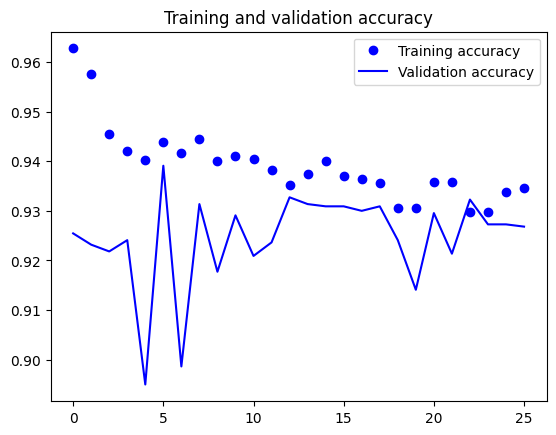

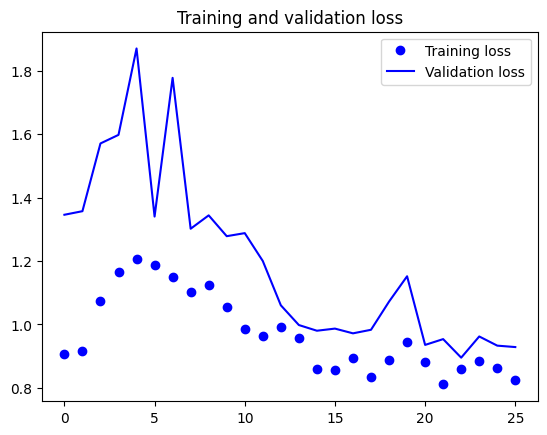

169/169 [==============================] - 3s 13ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9811    0.7767    0.8670       600
           1     0.9705    0.9317    0.9507       600
           2     0.9092    0.9017    0.9054       600
           3     0.7683    0.8820    0.8212       500
           4     0.9791    0.9380    0.9581       500
           5     0.8493    0.9300    0.8878       400
           6     0.8102    0.8540    0.8315       500
           7     0.9715    0.9650    0.9682       600
           8     0.8388    0.9260    0.8802       500
           9     0.9898    0.9700    0.9798       600

    accuracy                         0.9072      5400
   macro avg     0.9068    0.9075    0.9050      5400
weighted avg     0.9132    0.9072    0.9080      5400



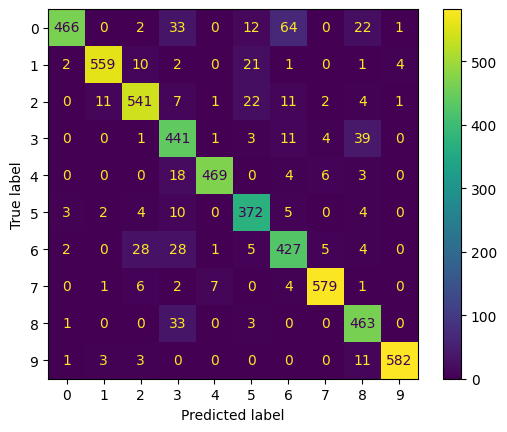

169/169 [==============================] - 2s 13ms/step


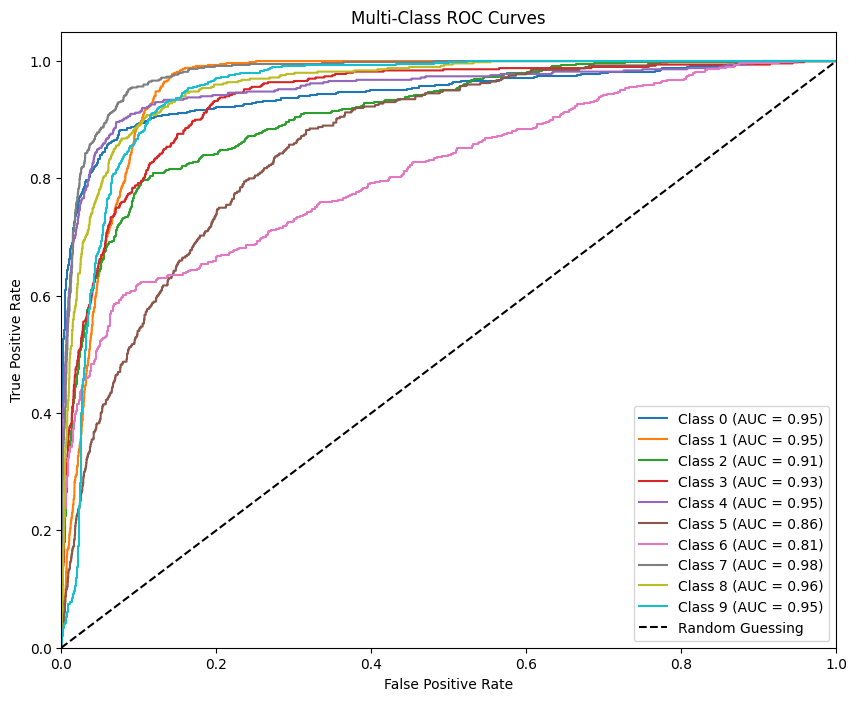

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,
    ),
    keras.callbacks.ModelCheckpoint(
        #'/content/drive/Shareddrives/Giaquinta_Pasqualetti/Models/resnet50_finetuned.h5',
        '/content/resnet50_finetuned.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    )
]

train, val, test = load_datasets(BATCH_SIZE = 64)
res = model.fit(train, epochs=30, validation_data=val, callbacks = callbacks_list)
train_performance(res)
show_res(model, test)
plot_multiclass_roc(model, test)

Fine tuning doesn't bring any advantage over the other models. Training is also less stable and accuracy a little bit lower.